<a href="https://colab.research.google.com/github/Fordalo/Data_SCIENCE_WORK/blob/main/SARIMAX.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##SARIMAX


*   X in SARIMAX denotes an exogenous variable
*   allows us to use more than one dependent variable  to forcast our target variable
*   predict one target with influence of other features



In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings

#for progression bars
from tqdm import tqdm_notebook
from itertools import product
from google.colab import drive
warnings.filterwarnings('ignore')
drive.mount('/content/gdrive')

%matplotlib inline
plt.rcParams['figure.figsize'] = (10, 7.5)

Mounted at /content/gdrive


In [ ]:

# we are using the united states Macroeconomic dataset
macro_data = sm.datasets.macrodata.load_pandas()
macro_data = macro_data.data
macro_data

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.980,139.7,2.82,5.8,177.146,0.00,0.00
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.150,141.7,3.08,5.1,177.830,2.34,0.74
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.350,140.5,3.82,5.3,178.657,2.74,1.09
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.370,140.0,4.33,5.6,179.386,0.27,4.06
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.540,139.6,3.50,5.2,180.007,2.31,1.19
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198,2008.0,3.0,13324.600,9267.7,1990.693,991.551,9838.3,216.889,1474.7,1.17,6.0,305.270,-3.16,4.33
199,2008.0,4.0,13141.920,9195.3,1857.661,1007.273,9920.4,212.174,1576.5,0.12,6.9,305.952,-8.79,8.91
200,2009.0,1.0,12925.410,9209.2,1558.494,996.287,9926.4,212.671,1592.8,0.22,8.1,306.547,0.94,-0.71
201,2009.0,2.0,12901.504,9189.0,1456.678,1023.528,10077.5,214.469,1653.6,0.18,9.2,307.226,3.37,-3.19


ABout the dataset:
Real GDP will be our observed variable
everything else will be our exogenous data

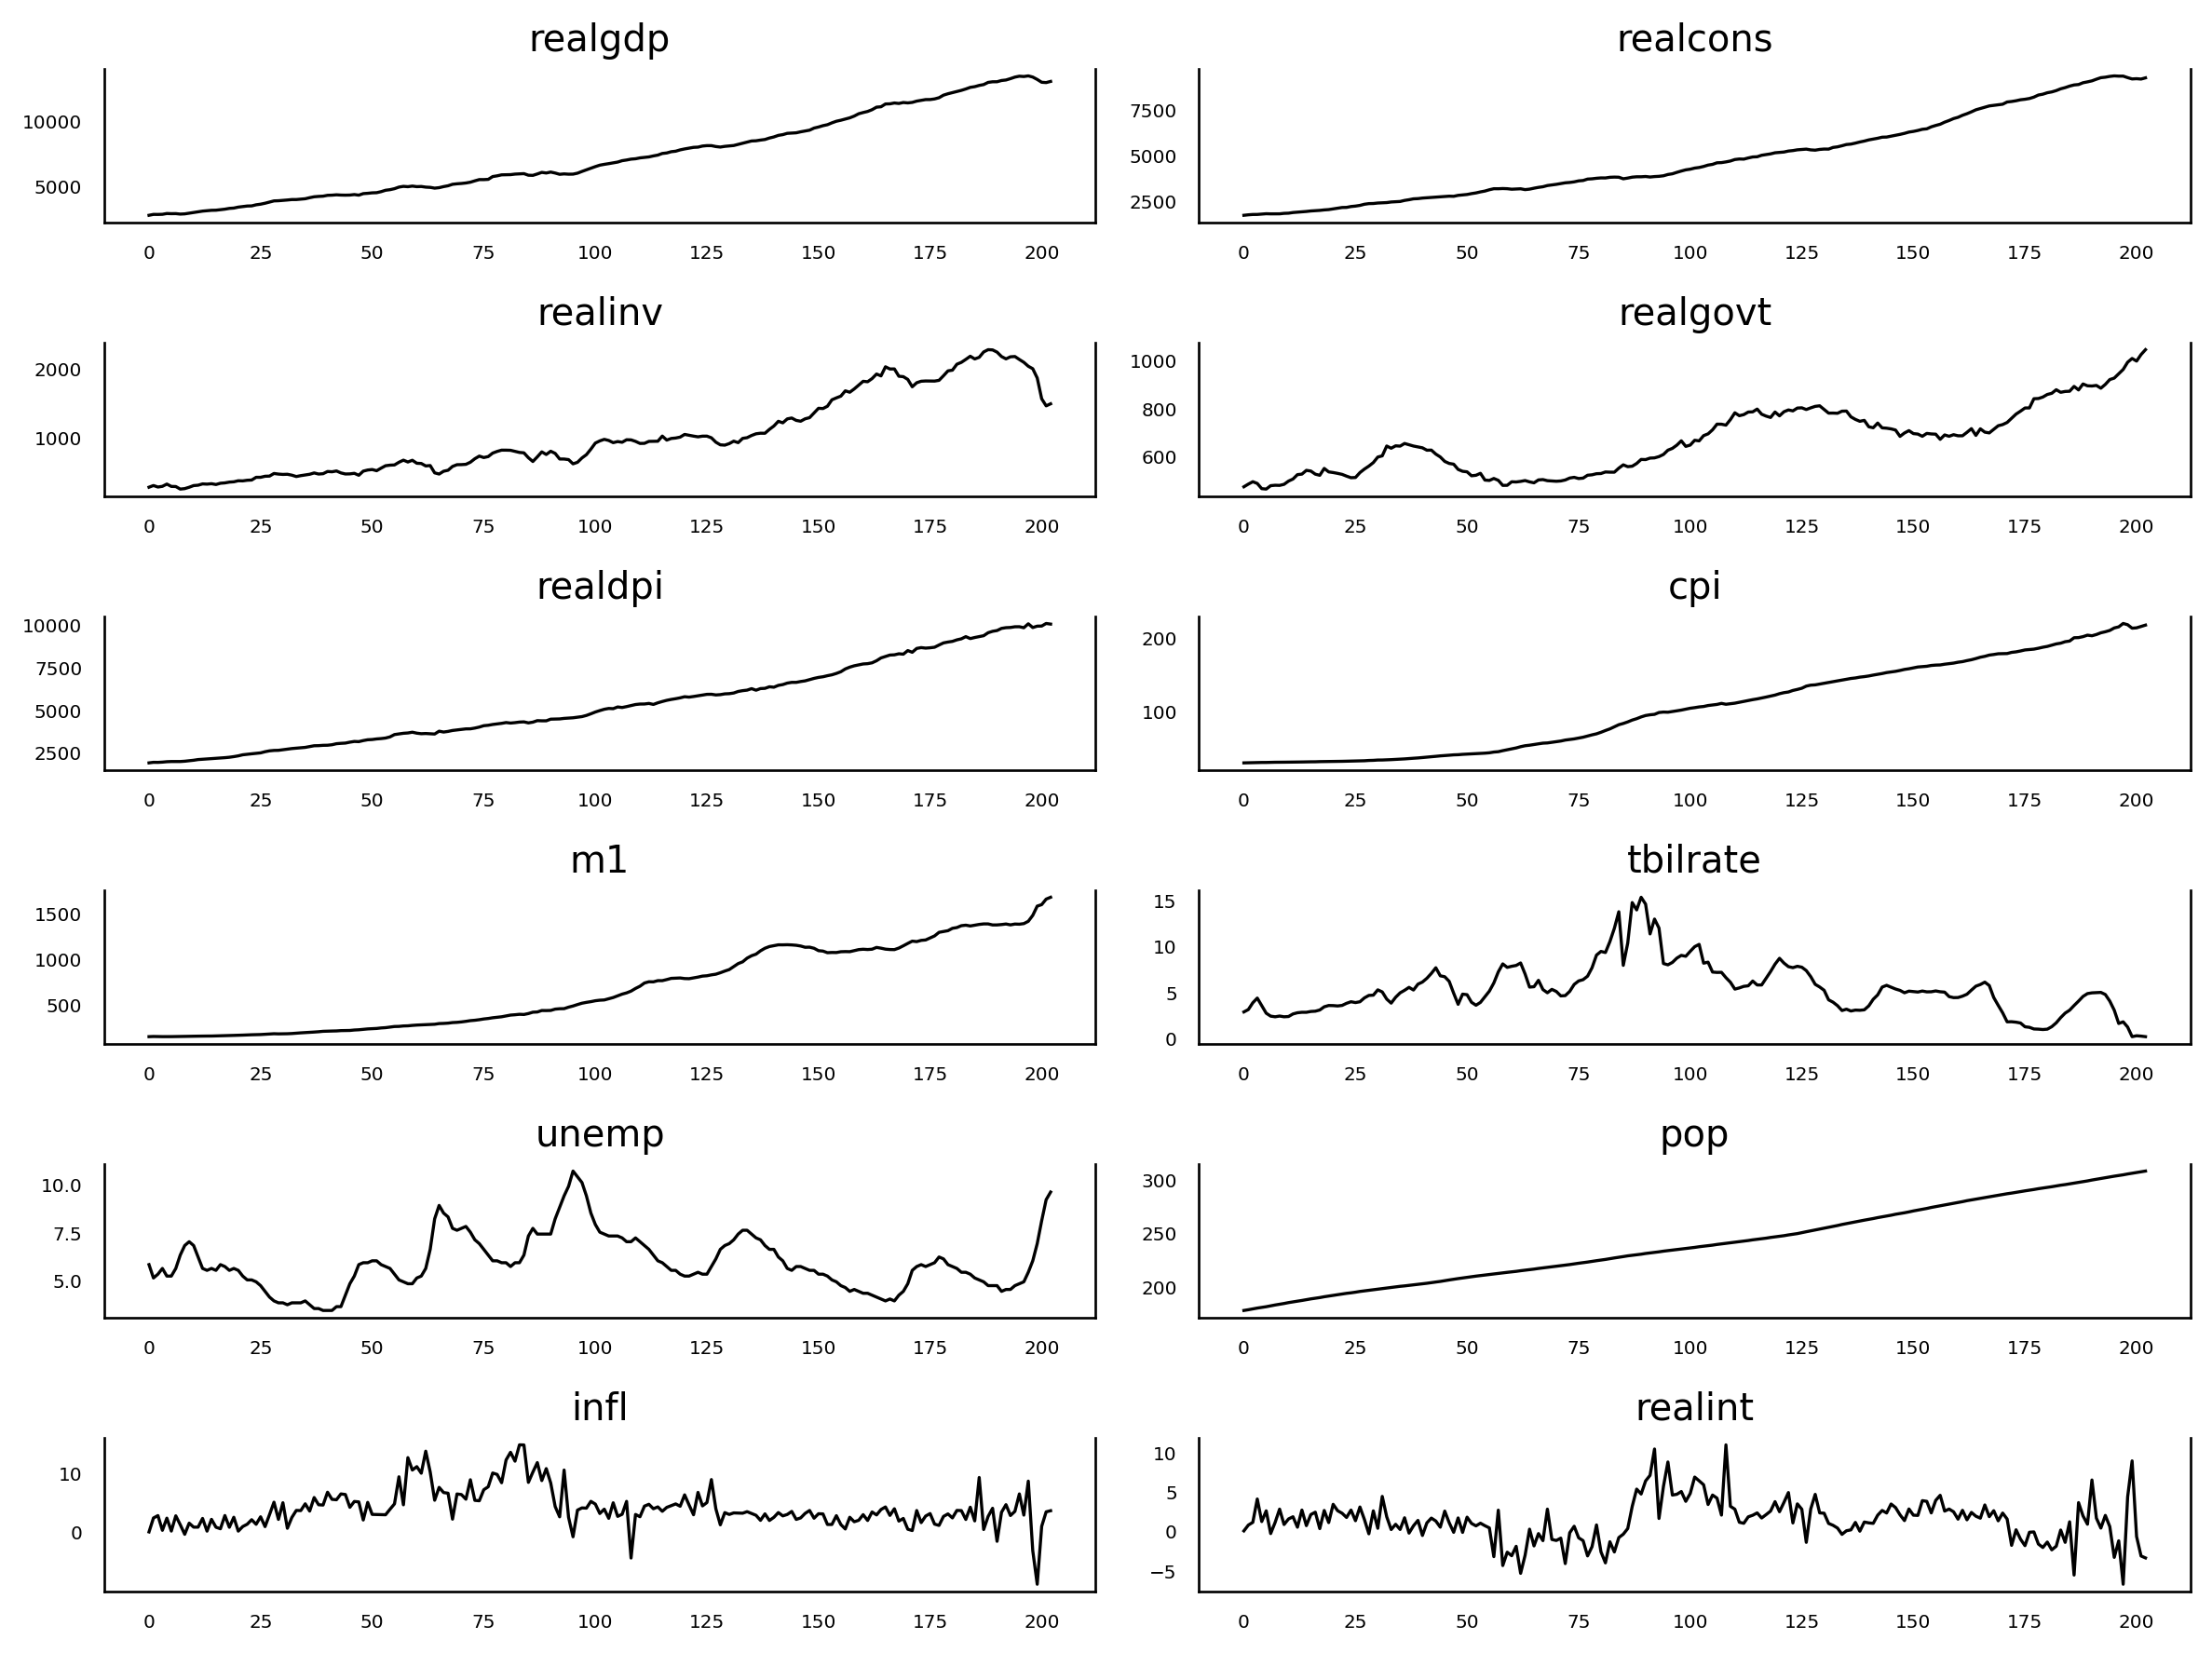

In [ ]:
fig, axes = plt.subplots(nrows= 6, ncols= 2, dpi= 240)

#flatten multiples the 6 X 2
for i, ax in enumerate(axes.flatten()):
  data = macro_data[macro_data.columns[i+2]]

  ax.plot(data, color = 'black', linewidth = 1)
  ax.set_title(macro_data.columns[i+2])
  ax.xaxis.set_ticks_position('none')
  ax.yaxis.set_ticks_position('none')
  ax.spines['top'].set_alpha(0)
  ax.tick_params(labelsize = 6)

plt.tight_layout()

In [ ]:
#obviously data is not stationary based on trends above
macro_data['GDPmod1'] = macro_data['realgdp'].diff()
macro_data.head()

,year,quarter,realgdp,realcons,realinv,realgovt,realdpi,cpi,m1,tbilrate,unemp,pop,infl,realint,GDPmod1
0,1959.0,1.0,2710.349,1707.4,286.898,470.045,1886.9,28.98,139.7,2.82,5.8,177.146,0.00,0.00,NaN
1,1959.0,2.0,2778.801,1733.7,310.859,481.301,1919.7,29.15,141.7,3.08,5.1,177.830,2.34,0.74,68.452
2,1959.0,3.0,2775.488,1751.8,289.226,491.260,1916.4,29.35,140.5,3.82,5.3,178.657,2.74,1.09,-3.313
3,1959.0,4.0,2785.204,1753.7,299.356,484.052,1931.3,29.37,140.0,4.33,5.6,179.386,0.27,4.06,9.716
4,1960.0,1.0,2847.699,1770.5,331.722,462.199,1955.5,29.54,139.6,3.50,5.2,180.007,2.31,1.19,62.495


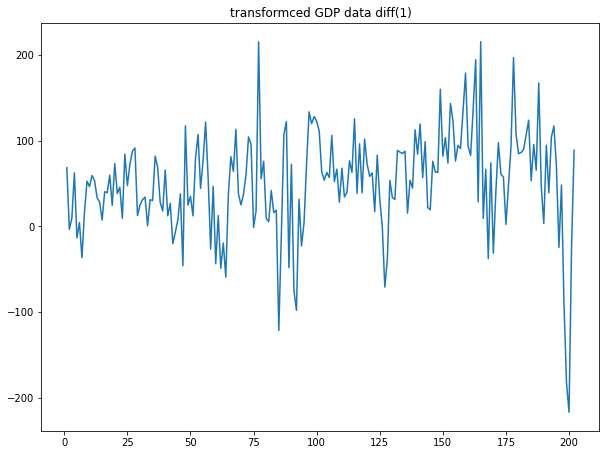

In [ ]:
plt.plot(macro_data['GDPmod1'])
plt.title('transformced GDP data diff(1)')
plt.show()

In [ ]:
#adfuller test for stationarity
# we just want to make sure

adfullresu = adfuller(macro_data['GDPmod1'][1:])
print(f'ADF STATISTIC: {adfullresu[0]} \n PVALUE: {adfullresu[1]}')

ADF STATISTIC: -6.305695561658106 
 PVALUE: 3.327882187668224e-08


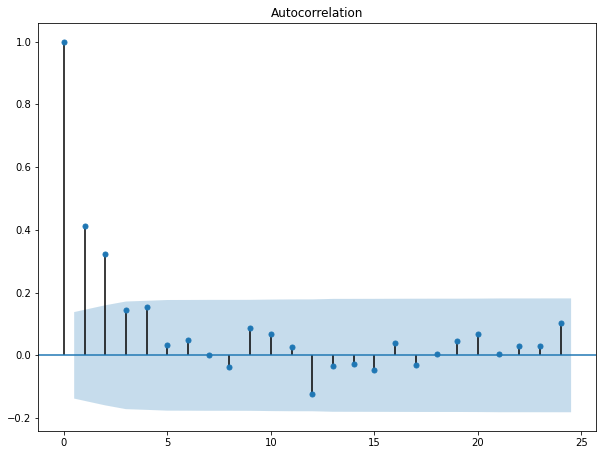

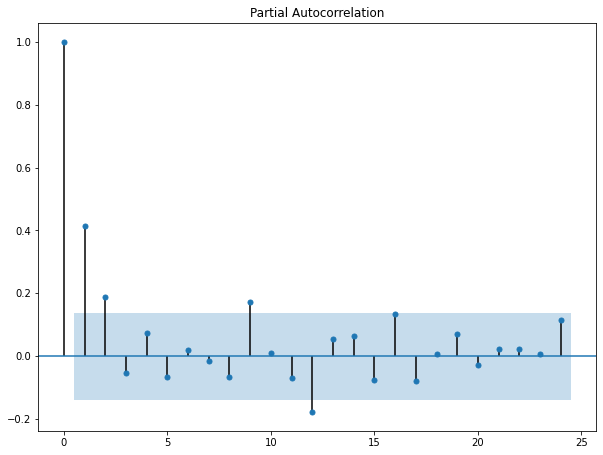

In [ ]:
#we will attempt to find the order of our model with ACF
#notice the sinusoidal points in both plots, we will need more
plot_acf(macro_data['GDPmod1'][1:]);
plot_pacf(macro_data['GDPmod1'][1:]);

In [ ]:
#Lets optomize our model to find the right parameters with a custom function

def optomize_SARIMAX(data, exog, param_list, d, D, s):
  """
    Will return dataframe with list of paramters and corresponding AIC
    Param_list = list of (p,q,P,Q) tuples
    d = integration order
    D = seasonal integration order
    s = length of season
    exog = other variables
    data = observed variable

  """

  #storing results in a list
  results = []

  for param in tqdm_notebook(param_list):
    try:
      model = SARIMAX(data, exog, order=(param[0], d, param[1]), seasonal_order= (param[2], D, param[3], s), simple_differencing= False).fit(disp= False)
    except:
      continue
    
    aic = model.aic
    results.append([param, aic])

  results_df = pd.DataFrame(results)
  results_df.columns = ['(p,q) & (P,Q)', 'AIC']


  results_df = results_df.sort_values(by= 'AIC', ascending = True).reset_index(drop = True)
  return results_df

#Creating our param list
p = range(0, 4, 1)
d = 1
q = range(0, 4, 1)
P = range(0, 4, 1)

#we are not taking a seasonal difference
D = 0
Q = range(0, 4, 1)
s = 4

parameters = product(p,q,P,Q)
param_list_test = list(parameters)
print(len(param_list_test))
print(param_list_test[0:20])

256
[(0, 0, 0, 0), (0, 0, 0, 1), (0, 0, 0, 2), (0, 0, 0, 3), (0, 0, 1, 0), (0, 0, 1, 1), (0, 0, 1, 2), (0, 0, 1, 3), (0, 0, 2, 0), (0, 0, 2, 1), (0, 0, 2, 2), (0, 0, 2, 3), (0, 0, 3, 0), (0, 0, 3, 1), (0, 0, 3, 2), (0, 0, 3, 3), (0, 1, 0, 0), (0, 1, 0, 1), (0, 1, 0, 2), (0, 1, 0, 3)]


In [ ]:
#training with first 200
traindata = macro_data['realgdp'][:200]
exog_train = macro_data[['realcons', 'realinv', 'realgovt', 'realdpi', 'cpi', 'm1', 'tbilrate', 'unemp', 'pop', 'infl', 'realint']][:200]

result_df = optomize_SARIMAX(traindata, exog_train, param_list_test, 1, 0, 4)
result_df

  0%|          | 0/256 [00:00<?, ?it/s]

,"(p,q) & (P,Q)",AIC
0,"(2, 2, 1, 0)",1757.124703
1,"(3, 3, 0, 0)",1757.893405
2,"(2, 2, 0, 2)",1758.330194
3,"(2, 2, 0, 0)",1759.094408
4,"(2, 2, 2, 0)",1759.515900
...,...,...
251,"(3, 2, 2, 1)",1776.806698
252,"(3, 2, 1, 3)",1776.867111
253,"(3, 2, 1, 1)",1776.944902
254,"(3, 2, 1, 2)",1778.132047


In [ ]:
#optimal = 2,2 for AR, 1,0 for Seasonal MA
best_model = SARIMAX(traindata, exog_train, order= (2,1,2), seasonal_order= (1,0,0,4), simple_differencing= False)
result = best_model.fit(disp = False)
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                           realgdp   No. Observations:                  200
Model:             SARIMAX(2, 1, 2)x(1, 0, 0, 4)   Log Likelihood                -861.562
Date:                           Sun, 14 Aug 2022   AIC                           1757.125
Time:                                   23:09:33   BIC                           1813.111
Sample:                                        0   HQIC                          1779.784
                                           - 200                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
realcons       0.9567      0.053     17.924      0.000       0.852       1.061
realinv        1.0010      0.042     24.038      0.000       0.919       1.083
realgovt       0.7463      0.139      5.376      0.000       0.474       1.018
realdpi        0.0187      0.024      0.777      0.437      -0.028       0.066
cpi            5.3633      2.085      2.573      0.010       1.277       9.449
m1            -0.0103      0.159     -0.065      0.948      -0.322       0.302
tbilrate      -3.7433     24.949     -0.150      0.881     -52.642      45.155
unemp         -7.9167      5.669     -1.397      0.163     -19.027       3.193
pop            5.7647      7.631      0.755      0.450      -9.191      20.721
infl          -0.6312     24.833     -0.025      0.980     -49.303      48.041
realint       -0.4603     24.783     -0.019      0.985     -49.034      48.114
ar.L1          1.8106      0.054     33.701      0.000       1.705       1.916
ar.L2         -0.8860      0.056    -15.903      0.000      -0.995      -0.777
ma.L1         -1.8084      0.041    -43.928      0.000      -1.889      -1.728
ma.L2          0.9400      0.038     24.510      0.000       0.865       1.015
ar.S.L4        0.1041      0.069      1.516      0.130      -0.031       0.239
sigma2       325.7208     30.211     10.782      0.000     266.508     384.933
===================================================================================
Ljung-Box (Q):                       26.51   Jarque-Bera (JB):                13.02
Prob(Q):                              0.95   Prob(JB):                         0.00
Heteroskedasticity (H):               3.98   Skew:                             0.25
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.15
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

We get back coef for our exogenous variables, coef for MA, and AR portion. PVALUE tells us significance of each variable. Lets see our residuals to see if its normally distributed

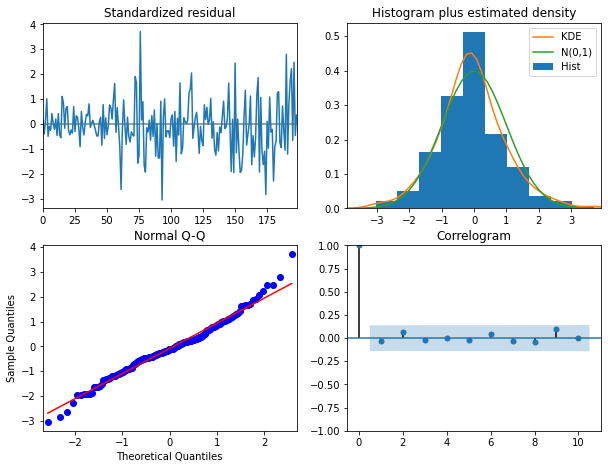

In [ ]:
result.plot_diagnostics();

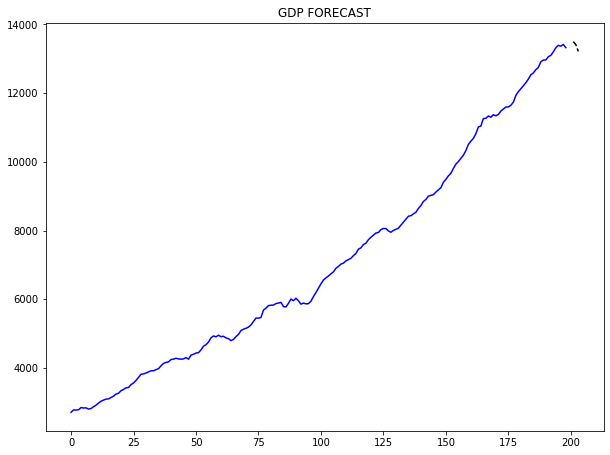

In [ ]:
#forecasting three steps aheasd
n_forecast = 3
predict = result.get_prediction(end = best_model.nobs + n_forecast, exog = exog_train.iloc[-4:])
idx = np.arange(len(predict.predicted_mean))
predict_ci = predict.conf_int(alpha = .5)

fig, ax = plt.subplots()
#training
ax.plot(macro_data['realgdp'][:199], color = 'blue')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')
ax.set_title('GDP FORECAST')
plt.show()

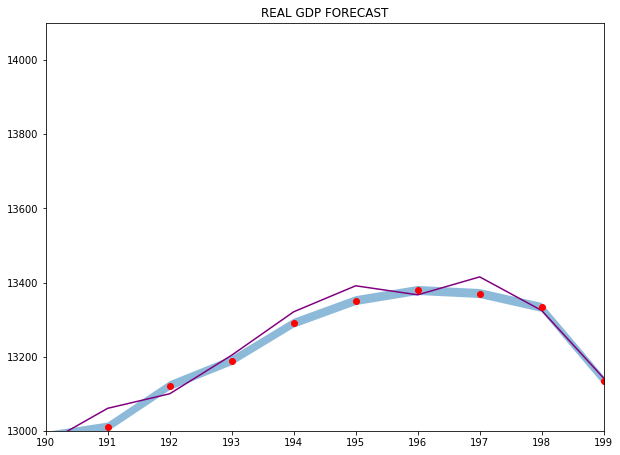

In [ ]:
#lets zoom in
fig, ax = plt.subplots()
#training
ax.plot(macro_data['realgdp'], color = 'purple')
ax.plot(idx[-n_forecast:], predict.predicted_mean[-n_forecast:], 'k--')

#ro means red circles
ax.plot(predict.predicted_mean, 'ro')
ax.fill_between(idx, predict_ci.iloc[: , 0], predict_ci.iloc[: , 1], alpha = .5)
ax.set_xlim(190, 199)
ax.set_ylim(13000, 14100)
ax.set_title('REAL GDP FORECAST')
plt.show()



In [ ]:
mse = mean_squared_error(macro_data['realgdp'], predict.predicted_mean[:203])
print(mse)

7056.12558830056


In [ ]:
#mean squared error is very large, ,we can get around this by calculating the mean percentage error
#mean absolute percentage error

mape = np.mean(np.abs(macro_data['realgdp'] - predict.predicted_mean[:203])/ np.abs(macro_data['realgdp']))
print(f'MAPE: {round(mape *100, 2)}%')

MAPE: 0.39%
